## Gravity - Spatial Interaction Model

[Dr Zahratu Shabrina](www.linkedin.com/in/zahratu-shabrina)

### 1. Overview
In this practical, we are going to explore the method of Gravity - Spatial Interaction Model to measure flow between areas. This practical is adapted from Adam Dennet's RPubs - modified according to our dataset, and converted into Python. *Thank you Adam for providing such a clear step by step approach for building the model!* 

There is also a package developed by Taylor Oshan for Spatial Interaction Model in PySal called SpInt https://github.com/pysal/spint - and you are welcomed to try it out. But, I think it's worth to do the model step by step so you understand the methodology and reasoning behind the model so the next time you are thinking to apply this method, you can tailor the code according to your needs.

### 2. Learning Outcomes 
By the end of the practical session, you should be able to:
- Prepare your data for gravity model specification
- Conduct a step-by-step (unconstrained) gravity-spatial interaction model
- Improve your model goodness of fit through model calibration
- Create a visualisation on your flow data

### 3. Dataset

I have downloaded all the datasets and put them in a zipped folder called data_practical9. 

1. Census 2001 commuting data for London Boroughs.
2. Borough Atlas containing essential socio-economic profiles of each London Borough.
3. Borough Boundary (shapefile).

### 4. Gravity-spatial interaction model

Let's refresh. Flows $T_{ij}$ from origin $i$ to destination $j$ can be modelled using the equation below:

$$T_{ij} = K \frac{O_i D_j}{(d_{ij})^\beta}$$

or more specifically,

$$T_{ij} = K \frac{V_i^\mu W_j^\alpha}{(d_{ij})^\beta}$$

or simplified as,
$$T_{ij} = K V_i^\mu W_j^\alpha d_{ij}^-\beta$$

$K$ is the scaling constant
$V_i$ is attraction in the origins $i$
$W_j$ is attraction in the destinations $j$
$d_{ij}$ is the deterrence factor
and $\mu$, $\alpha$, $\beta$ are the model parameters.


### 5. Data cleaning and model preparation 

In [1]:
# Load the necessary libraries
import pandas as pd # Data manipulation mainly for dataframe
import numpy as np # Data manipulation mainly for array
import matplotlib # Mapping
import matplotlib.pyplot as plt # Mapping
from mpl_toolkits.axes_grid1 import make_axes_locatable # For our map axes
import geopandas as gpd # Geodataframe
from scipy.spatial import distance_matrix # For Geodataframe
import networkx as nx # For creating the OD Matrix
from math import sqrt # To calculate goodness of fit stats
import statsmodels.api as sm # To build the poisson generalised linear model (GLM)
from statistics import mean # For calculating RMSE

# Some of the steps in this notebook might give us a 'setting with copy' warning
# as long as you check the data is correct, you can ignore the warning and set them up to not show them using this:
pd.options.mode.chained_assignment = None

As mentioned previously, we will be using three datasets.

Let's read in our first dataset containing the origins $O_i$ and $D_j$ destinations as well as the number of trips ($T_{ij}$).

In [2]:
# Read in the first dataset containing the Origins and Destinations according mode of transport
df_OD = pd.read_csv("/Users/zarashabrina/projects/gravity-model/data/LondonCommuting2001.csv")
df_OD.head()

,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,Train,Bus,Taxi,CarDrive,CarPass,Motobike,Bicycle,Walk,Other
0,City of London,00AA,City of London,00AA,2059,432,120,53,50,31,39,0,3,18,1272,41
1,City of London,00AA,Barking and Dagenham,00AB,6,0,3,3,0,0,0,0,0,0,0,0
2,City of London,00AA,Barnet,00AC,14,0,11,0,0,0,0,0,0,0,3,0
3,City of London,00AA,Bexley,00AD,0,0,0,0,0,0,0,0,0,0,0,0
4,City of London,00AA,Brent,00AE,16,0,10,0,3,0,0,0,0,0,3,0


In [3]:
# Read in the second dataset: Data on population, employment and income in Borough level
df_borough_raw = pd.read_csv("/Users/zarashabrina/projects/gravity-model/data/london-borough-profiles-clean.csv")
df_borough_raw.head()

,Code,Area_name,GLA_Population_Estimate_2017,hh_med_income_estimates_2012_13,Number_of_jobs_by_workplace_2014
0,E09000001,City of London,8800,63620,500400
1,E09000002,Barking and Dagenham,209000,29420,58900
2,E09000003,Barnet,389600,40530,167300
3,E09000004,Bexley,244300,36990,80700
4,E09000005,Brent,332100,32140,133600


In [4]:
# Read in the third dataset: The spatial data containing England and Wales boundary according to Borough
data = gpd.read_file("/Users/zarashabrina/projects/gravity-model/data/borough/London_Borough_Excluding_MHW.shp")
data.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18..."


### 5.1 Model specification: assigning origin's and destination's attractions

Good! Now that we have all the necessary datasets, we are going to prepare our data frame called **df_OD** to contain all the necessary information to build our model. What we can do is gradually build our model by adding the desired dataset. 

Looking back to this equation: $$T_{ij} = K V_i^\mu W_j^\alpha d_{ij}^-\beta$$

we already have the number of observed trips ($T_{ij}$) which is the "Total" column on our df_OD dataframe. 

In [5]:
# Select only the first 5 columns for simplicity, containing the information of our origins, 
# destinations and the number of trips between our OD
df_OD = df_OD.iloc[:,0:5]

In [6]:
# Change the column names so it's easier to identify our variables
df_OD.columns = ['orig_name','orig_code','dest_name','dest_code','trips']
df_OD.head()

,orig_name,orig_code,dest_name,dest_code,trips
0,City of London,00AA,City of London,00AA,2059
1,City of London,00AA,Barking and Dagenham,00AB,6
2,City of London,00AA,Barnet,00AC,14
3,City of London,00AA,Bexley,00AD,0
4,City of London,00AA,Brent,00AE,16


We still need to select our $V_i$ (the origin's attraction) and $W_j$ (the destination's attraction), as well as calculate distance between each origin and destination $d_{ij}$. To do this, let's explore our dataset by creating a map of London borough profiles.

In [7]:
# Merge our "data" geodataframe with "df_borough_raw" dataset using pandas merge function 
# based your merge on the same column values ("GSS_CODE" and "Code")
# save as "london" dataframe
london = pd.merge(data, df_borough_raw, left_on='GSS_CODE', right_on='Code')
london.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,Code,Area_name,GLA_Population_Estimate_2017,hh_med_income_estimates_2012_13,Number_of_jobs_by_workplace_2014
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",E09000021,Kingston upon Thames,175400,43940,83700
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",E09000008,Croydon,386500,37000,141600
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",E09000006,Bromley,327900,43060,127800
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",E09000018,Hounslow,274200,35330,165700
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",E09000009,Ealing,351600,36070,160500


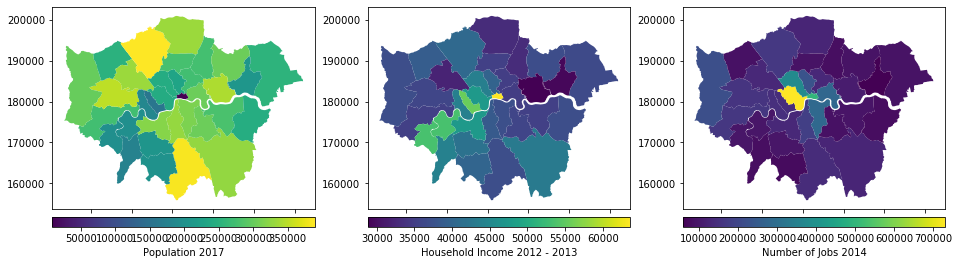

In [8]:
# Create a series of map showing the distribution of certain socio-economic variables in London

# First, let's assign the number of rows and columns, as well as our map size
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,16),subplot_kw=dict(aspect='equal'))

# We are using geopandas plot function and the sometimes the legend is acting strangely, so we need to adjust this
# we need to specify the legend axis by defining cax
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("bottom", size="5%", pad=0.1)

# Now plot our first map
ax1 = london.plot(column='GLA_Population_Estimate_2017', ax=ax1, legend=True, 
                  legend_kwds={'label': "Population 2017",
                               'orientation': "horizontal"}, cax=cax1)

# Complete the code below to incorporate more maps 
# Adjust legend for the second map - position them on the bottom and assign the same length as the map
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("bottom", size="5%", pad=0.1)

# Plot our second map
ax2 = london.plot(column='hh_med_income_estimates_2012_13', ax=ax2, legend=True, 
                  legend_kwds={'label': "Household Income 2012 - 2013",
                               'orientation': "horizontal"}, cax=cax2)
# Adjusting legend
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes("bottom", size="5%", pad=0.1)

#Plot our third map
ax3 = london.plot(column='Number_of_jobs_by_workplace_2014', ax=ax3, legend=True, 
                  legend_kwds={'label': "Number of Jobs 2014",
                               'orientation': "horizontal"}, cax=cax3)

Based on the map we can see that the population distribution is quite dispersed and the number of jobs is concentrated in the centre. We can assume that people live all over London but work in more concentrated areas. So, for today's demonstration we will assign:
- Population as $V_i$ using the assumption that a heavily populated origin would have more flows compared to lesser ones.
- Number of jobs as $W_j$ using the assumption that more people would be attracted to a destination if they have a higher number of jobs.

In [9]:
# Only select population (v_i) and economically_active (w_j)
df_borough = df_borough_raw.loc[:, ['Code','Area_name','GLA_Population_Estimate_2017','Number_of_jobs_by_workplace_2014']]

In [10]:
# Change the column name for simplicity
df_borough.columns = ['borough_code','borough_name','v_i','w_j']
df_borough.head()

,borough_code,borough_name,v_i,w_j
0,E09000001,City of London,8800,500400
1,E09000002,Barking and Dagenham,209000,58900
2,E09000003,Barnet,389600,167300
3,E09000004,Bexley,244300,80700
4,E09000005,Brent,332100,133600


In [11]:
# Now, we need to create a new column that adds the information of our origin's and destination's attractiveness (v_i)
df_OD['vi_orig'] = df_OD['orig_name'].map(df_borough.set_index('borough_name')['v_i'])
df_OD['vi_dest'] = df_OD['dest_name'].map(df_borough.set_index('borough_name')['v_i'])
print (df_OD)

           orig_name orig_code             dest_name dest_code  trips  \
0     City of London      00AA        City of London      00AA   2059   
1     City of London      00AA  Barking and Dagenham      00AB      6   
2     City of London      00AA                Barnet      00AC     14   
3     City of London      00AA                Bexley      00AD      0   
4     City of London      00AA                 Brent      00AE     16   
...              ...       ...                   ...       ...    ...   
1084     Westminster      00BK                Sutton      00BF     61   
1085     Westminster      00BK         Tower Hamlets      00BG   2851   
1086     Westminster      00BK        Waltham Forest      00BH    121   
1087     Westminster      00BK            Wandsworth      00BJ    873   
1088     Westminster      00BK           Westminster      00BK  46254   

      vi_orig  vi_dest  
0        8800     8800  
1        8800   209000  
2        8800   389600  
3        8800   244300 

In [12]:
# Add destination's attractiveness (w_j) to our OD data
df_OD['wj_orig'] = df_OD['orig_name'].map(df_borough.set_index('borough_name')['w_j'])
df_OD['wj_dest'] = df_OD['dest_name'].map(df_borough.set_index('borough_name')['w_j'])
print (df_OD)

           orig_name orig_code             dest_name dest_code  trips  \
0     City of London      00AA        City of London      00AA   2059   
1     City of London      00AA  Barking and Dagenham      00AB      6   
2     City of London      00AA                Barnet      00AC     14   
3     City of London      00AA                Bexley      00AD      0   
4     City of London      00AA                 Brent      00AE     16   
...              ...       ...                   ...       ...    ...   
1084     Westminster      00BK                Sutton      00BF     61   
1085     Westminster      00BK         Tower Hamlets      00BG   2851   
1086     Westminster      00BK        Waltham Forest      00BH    121   
1087     Westminster      00BK            Wandsworth      00BJ    873   
1088     Westminster      00BK           Westminster      00BK  46254   

      vi_orig  vi_dest  wj_orig  wj_dest  
0        8800     8800   500400   500400  
1        8800   209000   500400    58

### 5.2 Model specification: Calculating Euclidean distance
Euclidean distance is the straight line distance between two points in Euclidean space. In Python, we can simply calculate this using Geoseries.distance based on the centroids of two points.
See documentation here http://geopandas.org/reference.html

In [13]:
# First let's calculate the centroids of each polygon and save in a new column named "centroids}"
data['centroids'] = data['geometry'].centroid
data.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,centroids
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",POINT (519297.635 166820.011)
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",POINT (533290.154 163541.244)
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",POINT (542895.512 165655.521)
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",POINT (513515.506 175643.224)
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",POINT (515887.938 181715.496)


In [14]:
# Now, we need to assign these centroids to each of our origin and destination data
df_OD['orig_centroids'] = df_OD['orig_name'].map(data.set_index('NAME')['centroids'])
df_OD['dest_centroids'] = df_OD['dest_name'].map(data.set_index('NAME')['centroids'])
df_OD.head()

,orig_name,orig_code,dest_name,dest_code,trips,vi_orig,vi_dest,wj_orig,wj_dest,orig_centroids,dest_centroids
0,City of London,00AA,City of London,00AA,2059,8800,8800,500400,500400,POINT (532479.634 181271.833),POINT (532479.634 181271.833)
1,City of London,00AA,Barking and Dagenham,00AB,6,8800,209000,500400,58900,POINT (532479.634 181271.833),POINT (548040.122 185087.790)
2,City of London,00AA,Barnet,00AC,14,8800,389600,500400,167300,POINT (532479.634 181271.833),POINT (524027.595 192316.340)
3,City of London,00AA,Bexley,00AD,0,8800,244300,500400,80700,POINT (532479.634 181271.833),POINT (548794.417 175487.156)
4,City of London,00AA,Brent,00AE,16,8800,332100,500400,133600,POINT (532479.634 181271.833),POINT (520177.868 185829.516)


In [15]:
# we can calculate the distance between two origin and destination points and save the value in a new column "dist"
df_OD['dist'] = gpd.GeoSeries(df_OD['orig_centroids']).distance(gpd.GeoSeries(df_OD['dest_centroids']))
df_OD.head()

,orig_name,orig_code,dest_name,dest_code,trips,vi_orig,vi_dest,wj_orig,wj_dest,orig_centroids,dest_centroids,dist
0,City of London,00AA,City of London,00AA,2059,8800,8800,500400,500400,POINT (532479.634 181271.833),POINT (532479.634 181271.833),0.000000
1,City of London,00AA,Barking and Dagenham,00AB,6,8800,209000,500400,58900,POINT (532479.634 181271.833),POINT (548040.122 185087.790),16021.558494
2,City of London,00AA,Barnet,00AC,14,8800,389600,500400,167300,POINT (532479.634 181271.833),POINT (524027.595 192316.340),13907.482873
3,City of London,00AA,Bexley,00AD,0,8800,244300,500400,80700,POINT (532479.634 181271.833),POINT (548794.417 175487.156),17309.958173
4,City of London,00AA,Brent,00AE,16,8800,332100,500400,133600,POINT (532479.634 181271.833),POINT (520177.868 185829.516),13118.913728


In [16]:
# Drop any data with missing values
df_OD = df_OD.dropna()
df_OD.head()

,orig_name,orig_code,dest_name,dest_code,trips,vi_orig,vi_dest,wj_orig,wj_dest,orig_centroids,dest_centroids,dist
0,City of London,00AA,City of London,00AA,2059,8800,8800,500400,500400,POINT (532479.634 181271.833),POINT (532479.634 181271.833),0.000000
1,City of London,00AA,Barking and Dagenham,00AB,6,8800,209000,500400,58900,POINT (532479.634 181271.833),POINT (548040.122 185087.790),16021.558494
2,City of London,00AA,Barnet,00AC,14,8800,389600,500400,167300,POINT (532479.634 181271.833),POINT (524027.595 192316.340),13907.482873
3,City of London,00AA,Bexley,00AD,0,8800,244300,500400,80700,POINT (532479.634 181271.833),POINT (548794.417 175487.156),17309.958173
4,City of London,00AA,Brent,00AE,16,8800,332100,500400,133600,POINT (532479.634 181271.833),POINT (520177.868 185829.516),13118.913728


In [17]:
# For our model, let's delete some "intra-commute" or commuting within borough 
# This is because we are more interested in the commuting data BETWEEN boroughs
# Using "query" function, only select data where origins are not the same with destinations 
# (deleting intra-commute)
df_OD = df_OD.query('orig_code != dest_code')

We have prepared our dataset to include origins, destinations, the measure of attractiveness and distance. Now we can start specifying our model.

### 6. Building our unconstrained gravity-spatial interaction model!
After our data is prepared, it is time to build our model! 
First, we are going to set up an initial model using parameter estimates that we chose ourselves based on literature review. 

### 6.1 The initial model

In [18]:
# set up some variables to hold our parameter values in:
# these initial values are chosen according to the usual range from the model parameter results in previous studies
# the purpose is to setup a baseline model where we can start to improve our model on
mu = 1.0            # parameter estimate for origin's attractiveness 
alpha = 1.0         # parameter estimate for destination's attractiveness 
beta = -2.0         # parameter estimate for distance measure
k = 1.0             # scaling constant
T2 = sum(df_OD['trips'])

Let's calculate $V_i^\mu$ for each row

In [19]:
vi1_mu = df_OD['vi_orig']**mu
vi1_mu.head()

1    8800.0
2    8800.0
3    8800.0
4    8800.0
5    8800.0
Name: vi_orig, dtype: float64

Calculate $W_j^\alpha$ as *wj2_alpha* and $D_{ij}^\beta$ as *dist_beta* for each row according to the example above and display part of the data

In [20]:
wj2_alpha = df_OD['wj_dest']**alpha
wj2_alpha.head()

1     58900.0
2    167300.0
3     80700.0
4    133600.0
5    127800.0
Name: wj_dest, dtype: float64

In [21]:
dist_beta = df_OD['dist']**beta
dist_beta.head()

1    3.895745e-09
2    5.170147e-09
3    3.337398e-09
4    5.810376e-09
5    2.838009e-09
Name: dist, dtype: float64

Now, we can calculate the estimated flows based on our model using this equation below:
    $$T_{ij} = K V_i^\mu W_j^\alpha d_{ij}^-\beta$$

In [22]:
# Save the estimated flow based on our initial model as T1
T1 = vi1_mu*wj2_alpha*dist_beta
T1.head()

1    2.019242
2    7.611698
3    2.370086
4    6.831143
5    3.191738
dtype: float64

In [23]:
k = T2/sum(T1)
k

3.9034204834437407

In [24]:
#run the model and store all of the new flow estimates in a new column in the dataframe
df_OD['unconstrainedEst1'] = round(k*vi1_mu*wj2_alpha*dist_beta,2)
#check that the sum of these estimates makes sense
sum(df_OD['unconstrainedEst1'])

1800412.9399999995

According to our initial model, there are more than 1.8 million trips across boroughs. Let's compare this with our observed trip data.

In [25]:
# Calculate the sum of our observed flow (hint: "trips" column)
sum(df_OD['trips'])

1800413

Wow, the number is actually very very close, but how close is our model in terms of predicting the trip distribution in each borough?

In [26]:
# Let's double check if our data frame has included the estimated flow ('unconstrainedEst1')
df_OD.head()

,orig_name,orig_code,dest_name,dest_code,trips,vi_orig,vi_dest,wj_orig,wj_dest,orig_centroids,dest_centroids,dist,unconstrainedEst1
1,City of London,00AA,Barking and Dagenham,00AB,6,8800,209000,500400,58900,POINT (532479.634 181271.833),POINT (548040.122 185087.790),16021.558494,7.88
2,City of London,00AA,Barnet,00AC,14,8800,389600,500400,167300,POINT (532479.634 181271.833),POINT (524027.595 192316.340),13907.482873,29.71
3,City of London,00AA,Bexley,00AD,0,8800,244300,500400,80700,POINT (532479.634 181271.833),POINT (548794.417 175487.156),17309.958173,9.25
4,City of London,00AA,Brent,00AE,16,8800,332100,500400,133600,POINT (532479.634 181271.833),POINT (520177.868 185829.516),13118.913728,26.66
5,City of London,00AA,Bromley,00AF,0,8800,327900,500400,127800,POINT (532479.634 181271.833),POINT (542895.512 165655.521),18771.247040,12.46


Now let's display our flow as a matrix

In [27]:
# Create an OD Matrix using pivot function
# What it does is creating an origin and destination matrix where you can assign the value you would like to show
# here, we'll be displaying 'unconstrainedEst1' to show the model's estimated trip values 
od_pivot = df_OD.pivot(index='orig_name', columns='dest_name', values='unconstrainedEst1')

In [28]:
# We need to change any null values and set them to 0
od_pivot = od_pivot.fillna(0)

In [29]:
# Total sum per column: 
od_pivot.loc['Total',:]= od_pivot.sum(axis=0)
# Total sum per row: 
od_pivot.loc[:,'Total'] = od_pivot.sum(axis=1)
# OD flow
od_pivot.head

<bound method NDFrame.head of dest_name               Barking and Dagenham    Barnet    Bexley     Brent  \
orig_name                                                                    
Barking and Dagenham                    0.00    217.04    709.89    140.30   
Barnet                                142.44      0.00    136.88   3570.79   
Bexley                                605.64    177.93      0.00    137.60   
Brent                                  98.29   3811.57    112.99      0.00   
Bromley                               186.57    200.72    785.73    185.25   
Camden                                136.91   2161.11    146.26   2092.33   
City of London                          7.88     29.71      9.25     26.66   
Croydon                               130.33    276.21    317.81    301.42   
Ealing                                 77.35   1285.38     98.75   5190.07   
Enfield                               205.64   2489.67    148.54    662.46   
Greenwich                         

That looks pretty good! Now let's check our model fit in terms of how well the model can predict the observed trips.

### 6.2 Testing the model's goodness of fit
In testing the model's goodness of fit, we will use R-squared and RMSE.

In [30]:
# Create function to calculate R-squared
def calcRSquared(observed, estimated):
    r = observed.corr(estimated)
    R2 = r**2
    return R2

r_squared = calcRSquared(df_OD['trips'],df_OD['unconstrainedEst1'])
print(r_squared)

0.4378169033135482


So, what does it mean? 
The model could explain around 43% of the trips happening between London Boroughs. For a real dataset, this is quite good. But, we might be able to improve this considering that we just guessed the value of our estimated parameters. Once we calibrate our parameters, we can compare them with this initial R-squared and see if the model improves.

In [31]:
def calcRMSE(observed, estimated):
    res = (observed - estimated)**2
    RMSE = round(sqrt(mean(res)),3)
    return RMSE
    
RMSE = calcRMSE(df_OD['trips'],df_OD['unconstrainedEst1'])
print(RMSE)

3339.47


"Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit." 
https://www.statisticshowto.datasciencecentral.com/rmse/

So, when all the points lie within the regression line (perfect correlation), our RMSE will be 0. Thus, a lower RMSE is better for our model fit 

### Improving our model's goodness of fit 

Now the real challenge is to actually improve our goodness of fit by calibrating our model's parameter. 

"Spatial interaction models are often calibrated via linear programming, nonlinear optimization, or, increasingly more often, through linear regression. By taking the natural logarithm of both sides of a spatial interaction model, say the basic gravity model, it is possible to obtain the so-called log-linear or log-normal spatial interaction model." (Oshan, 2016).

So, we will take the power function of our model - if ln $T_{ij}$ is denoted as $\lambda_{ij}$, then:

$$ \lambda_{ij} = exp (k+ \mu ln V_{i} + \alpha ln W_j - \beta ln d_{ij}) $$

In [32]:
# So, we need to take the natural logarithm for our Vi and Wj 
# Using iloc to locate your data, for example:
df_OD.iloc[:,11]

1       16021.558494
2       13907.482873
3       17309.958173
4       13118.913728
5       18771.247040
            ...     
1083     7536.495387
1084    16924.694963
1085     8732.806599
1086    13627.644658
1087     7173.125661
Name: dist, Length: 1056, dtype: float64

In [33]:
# Change to logarithmic form
df_OD['log_vi_orig'] = np.log(df_OD.iloc[:,5])
df_OD['log_wj_dest'] = np.log(df_OD.iloc[:,8])
df_OD['log_dist'] = np.log(df_OD.iloc[:,11])

In [34]:
# We need to make sure that our data do not have NAN and Inf - otherwise the result would not be reliable
df_OD = df_OD.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [35]:
# Check our data and make sure they include the log values 
df_OD.head()

,orig_name,orig_code,dest_name,dest_code,trips,vi_orig,vi_dest,wj_orig,wj_dest,orig_centroids,dest_centroids,dist,unconstrainedEst1,log_vi_orig,log_wj_dest,log_dist
1,City of London,00AA,Barking and Dagenham,00AB,6,8800,209000,500400,58900,POINT (532479.634 181271.833),POINT (548040.122 185087.790),16021.558494,7.88,9.082507,10.983596,9.681691
2,City of London,00AA,Barnet,00AC,14,8800,389600,500400,167300,POINT (532479.634 181271.833),POINT (524027.595 192316.340),13907.482873,29.71,9.082507,12.027544,9.540182
3,City of London,00AA,Bexley,00AD,0,8800,244300,500400,80700,POINT (532479.634 181271.833),POINT (548794.417 175487.156),17309.958173,9.25,9.082507,11.298494,9.759037
4,City of London,00AA,Brent,00AE,16,8800,332100,500400,133600,POINT (532479.634 181271.833),POINT (520177.868 185829.516),13118.913728,26.66,9.082507,11.802606,9.481810
5,City of London,00AA,Bromley,00AF,0,8800,327900,500400,127800,POINT (532479.634 181271.833),POINT (542895.512 165655.521),18771.247040,12.46,9.082507,11.758222,9.840082


In [36]:
# Determine our independent and dependent variables
X = df_OD[['log_vi_orig','log_wj_dest','log_dist']]     # independent variables
Y = df_OD['trips']                                      # dependent variables
# adding a constant to our linear model
X = sm.add_constant(X.values)

In [37]:
# Run the unconstrained model and display the model summary
# don't forget to identify that our model is a Poisson model
model = sm.GLM(Y, X, family=sm.families.Poisson())
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  trips   No. Observations:                 1056
Model:                            GLM   Df Residuals:                     1052
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.8453e+05
Date:                Thu, 11 Jun 2020   Deviance:                   7.6065e+05
Time:                        10:30:03   Pearson chi2:                 9.43e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.5930      0.043   -223.160      0.000      -9.677      -9.509
x1             1.2530      0.003    383.170      0.000       1.247       1.259
x2             1.0831      0.001   1018.828      0.000       1.081       1.085
x3            -1.2502      0.001   -969.788      0.000      -1.253      -1.248
==============================================================================
"""

In [38]:
# set up some variables to hold our parameter values in:
# these values are taken from the coefficients based on the poisson generalised linear model (GLM)
# the purpose is to setup a baseline model where we can start to improve our model on
# Complete the calibrated model parameters using the values from the GLM results above
mu = 1.253          # parameter estimate for origin's attractiveness - based on log_vi_orig coefficient
alpha = 1.0831      # parameter estimate for destination's attractiveness - based on log_wj_coefficient
beta = 1.2502       # parameter estimate for distance measure - based on log_dist coefficient
k = -9.5930         # scaling constant
T2 = sum(df_OD['trips'])

Let's calculate our estimated flows using the equation:
$$ \lambda_{ij} = exp (k+ \mu ln V_{i} + \alpha ln W_j - \beta ln d_{ij}) $$


In [39]:
# Calculate the estimated flow using the equation above and save them as "unconstrainedEst2"
unconstrainedEst2 = (np.exp(k)*np.exp(mu*df_OD['log_vi_orig'])*
                     np.exp(alpha*df_OD['log_wj_dest'])*
                     np.exp(-beta*df_OD['log_dist']))
unconstrainedEst2.head()

1     4.853330
2    17.944401
3     6.196791
4    15.129162
5     9.213238
dtype: float64

In [40]:
# run the model and store all of the new flow estimates in a new column in the dataframe
df_OD['unconstrainedEst2'] = round(unconstrainedEst2,2)

# check that the sum of these estimates makes sense
sum(df_OD['unconstrainedEst2'])

1799033.0400000005

In [41]:
# Remember that we have already created a function to calculate R-squared as calcRsquared
# Calculate R-squared for Fitted Estimate and see if the value improves compared to our initial model
r_squared2 = calcRSquared(df_OD['trips'],df_OD['unconstrainedEst2'])
print(r_squared2)

0.6764209490438859


In [42]:
# We have also created a function to calculate RMSE as calcRMSE
# Calculate RMSE for Fitted Estimate and see if the value improves compared to our initial model
RMSE = calcRMSE(df_OD['trips'],df_OD['unconstrainedEst2'])
print(RMSE)

1716.258


With the model calibration, we managed to actually improve R-squared and at the same time reduce our Root Mean Squared Error (RMSE). It means that we have improved the amount of the variance explained by the model and help minimise the missing information. YEAY.

### 6.3 Mapping our model's flow

We are going to create a flow map using the NetworkX package in Python. We will need to prepare:
- A CSV table containing the borough name/borough code of your origins and destinations - this is our df_OD data frame
- A CSV table with the information of the latitude and longitude of each borough - we will assign this to df_borough data frame
- A base map - this could be the shapefile

In [43]:
# We need to convert our Geodatframe to pandas dataframe to get the latitude and longitude in separate columns
data_pd = pd.DataFrame(data)
data_pd.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,centroids
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",POINT (519297.635 166820.011)
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",POINT (533290.154 163541.244)
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",POINT (542895.512 165655.521)
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",POINT (513515.506 175643.224)
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",POINT (515887.938 181715.496)


In [44]:
# Add centroids information to our df_borough dataframe
df_borough['centroids'] = df_borough['borough_code'].map(data_pd.set_index('GSS_CODE')['centroids'])

In [45]:
# We need to create separate columns for our latitude and longitude
df_borough['lon'] = df_borough['centroids'].apply(lambda p: p.x)
# Complete this code to include 'lat' column
df_borough['lat'] = df_borough['centroids'].apply(lambda p: p.y)
df_borough.head()

,borough_code,borough_name,v_i,w_j,centroids,lon,lat
0,E09000001,City of London,8800,500400,POINT (532479.634 181271.833),532479.633543,181271.833312
1,E09000002,Barking and Dagenham,209000,58900,POINT (548040.122 185087.790),548040.122277,185087.790195
2,E09000003,Barnet,389600,167300,POINT (524027.595 192316.340),524027.594903,192316.339761
3,E09000004,Bexley,244300,80700,POINT (548794.417 175487.156),548794.417061,175487.156077
4,E09000005,Brent,332100,133600,POINT (520177.868 185829.516),520177.868431,185829.516116


In [46]:
# Create graph
graph = nx.from_pandas_edgelist(df_OD, 'orig_name', 'dest_name',
                                edge_attr = 'unconstrainedEst2', create_using = nx.DiGraph())

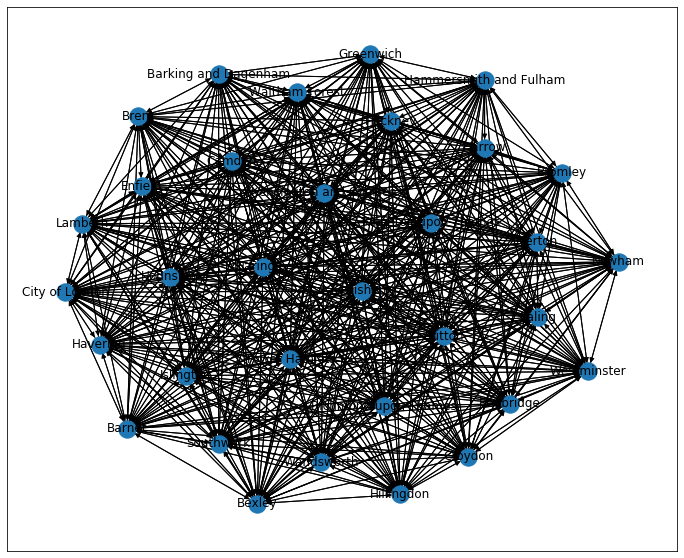

In [47]:
# default graph using Networkx inbuilt graph tools
plt.figure(figsize = (12,10))
nx.draw_networkx(graph)
plt.show()

What do you think? We can't really see the context and only be able to see the points of origins and destinations.
Also, we can definitely improve the appearance.

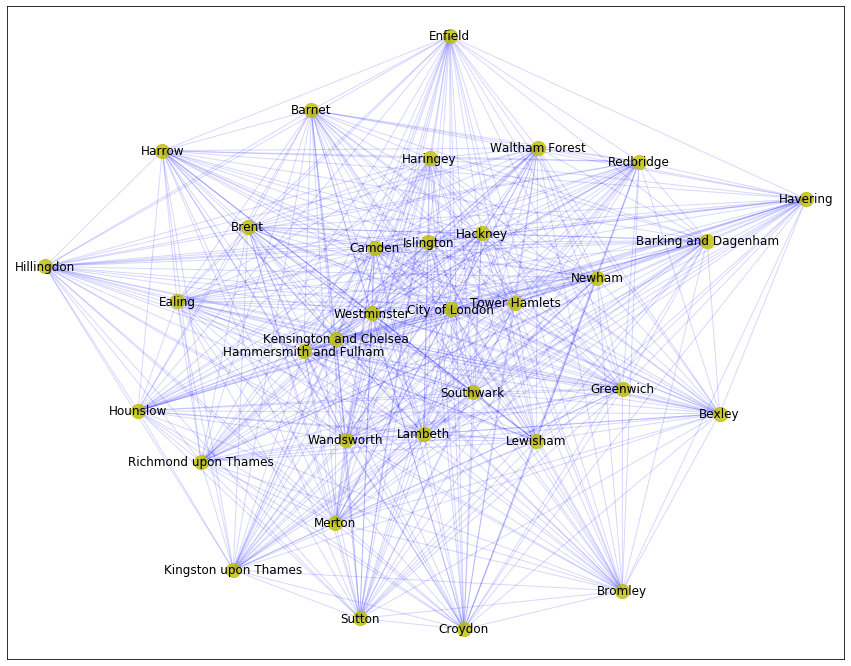

In [48]:
# Create graph
graph = nx.from_pandas_edgelist(df_OD, 'orig_name', 'dest_name',
                                edge_attr = 'unconstrainedEst1', create_using = nx.DiGraph())

# Creating the flow map

# Setting the size of our map
plt.figure(figsize = (15,12))

# Assign the geographical locations of our Borough points
mx, my = (df_borough['lon'].values, df_borough['lat'].values)

pos = {}

for count, elem in enumerate (df_borough['borough_name']):
     pos[elem] = (mx[count], my[count])

# Draw the map using NetworkX        
nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(),
                       node_color = 'y', alpha = 0.8, node_size = 200, with_labels=True)
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='b', alpha=0.08, arrows = False)
nx.draw_networkx_labels(G = graph, pos=pos)

plt.show()

**Try**: Reproduce the flow map for observed trip to provide a comparison between the observed and estimated trips.


**CONGRATULATION ON COMPLETING THIS PRACTICAL!!**

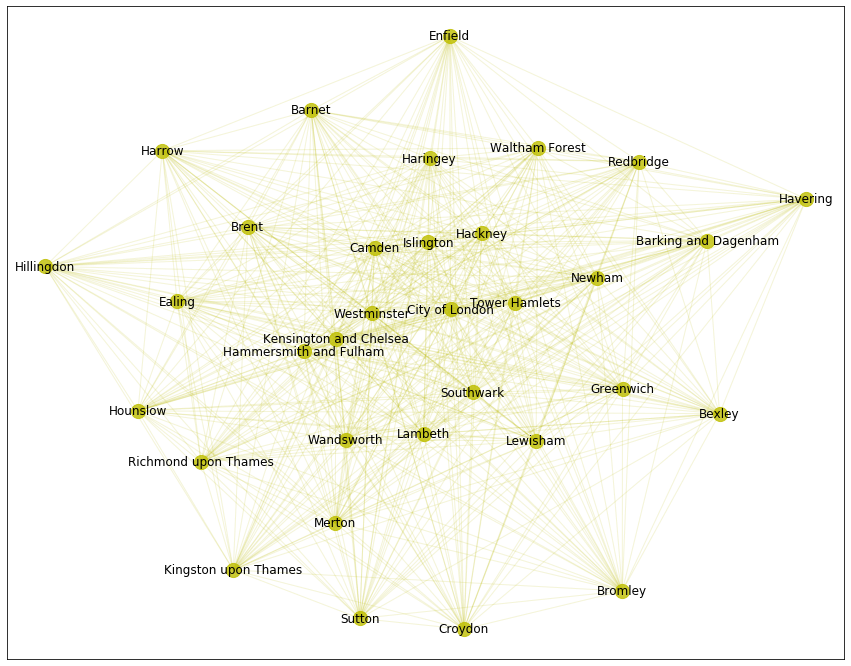

In [49]:
# Create graph
graph = nx.from_pandas_edgelist(df_OD, 'orig_name', 'dest_name',
                                edge_attr = 'trips', create_using = nx.DiGraph())

# Creating the flow map

# Setting the size of our map
plt.figure(figsize = (15,12))

# Assign the geographical locations of our Borough points
mx, my = (df_borough['lon'].values, df_borough['lat'].values)

pos = {}

for count, elem in enumerate (df_borough['borough_name']):
     pos[elem] = (mx[count], my[count])

# Draw the map using NetworkX        
nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(),
                       node_color = 'y', alpha = 0.8, node_size = 200, with_labels=True)
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='y', alpha=0.08, arrows = False)
nx.draw_networkx_labels(G = graph, pos=pos)

plt.show()

### Extras!

This document only covers how to build an unconstrained gravity-spatial interaction model. Of course, we also have singly (production or attraction) constrained and doubly constrained models. 

Production-constrained:
$$ T_{ij} = A_i O_i W_j^\alpha f(d_{ij}) $$
$$ A_i = \sum_{j} W_j^\alpha f(d_{ij}) $$

Attraction-constrained:
$$ T_{ij} = B_j D_j V_i^\mu f(d_{ij}) $$
$$ B_j = \sum_{i} V_i^\mu f(d_{ij}) $$

Doubly-constrained:
$$ T_{ij} = A_i B_j O_i D_j f(d_{ij}) $$
$$ A_i = \sum_{j} W_j^\alpha B_j D_j f(d_{ij}) $$
$$ B_j = \sum_{i} V_i^\mu A_i O_i f(d_{ij}) $$

If you are interested to learn more, check these links below. 

### More to learn...

Oshan, T.M., 2016. A primer for working with the Spatial Interaction modeling (SpInt) module in the python spatial analysis library (PySAL). Region, 3(2), pp.R11-R23. Available at https://www.researchgate.net/publication/311477750_A_primer_for_working_with_the_Spatial_Interaction_modeling_SpInt_module_in_the_python_spatial_analysis_library_PySAL

### Credit

Dr Ds Idiots Guide to Spatial Interaction Modelling for Dummies - Part 1: The Unconstrained (Total Constrained) Model by Adam Dennett available here https://rpubs.com/adam_dennett/257231

Dr Ds Idiots Guide to Spatial Interaction Modelling for Dummies - Part 2: Constrained Models by Adam Dennett available here https://rpubs.com/adam_dennett/259068

Catching that flight: Visualizing social network with Networkx and Basemap by Tuan Doan Nguyen
https://towardsdatascience.com/catching-that-flight-visualizing-social-network-with-networkx-and-basemap-ce4a0d2eaea6
    